In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import requests
import json
import utils
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import autoreload
%load_ext autoreload
%autoreload 2
from glob import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Write lat longs

In [9]:
latlong = {}
latlong['denver'] = (39.7643179,-104.9251504)
latlong['london'] = (51.5286208,-0.1716374)
latlong['christchurch'] = (-43.5950779,172.4718639)

In [13]:
with open('latlong.json','w') as f:
    json.dump(latlong,f,indent=True)

In [15]:
latlong = utils.read_latlong()

In [17]:
latlong

{'denver': [39.7643179, -104.9251504],
 'london': [51.5286208, -0.1716374],
 'christchurch': [-43.5950779, 172.4718639]}

## Sample call 
https://darksky.net/dev/docs#time-machine-request

In [16]:
key = utils.read_key()

In [20]:
## https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]
endpt = 'https://api.darksky.net/forecast'

In [33]:
lat,long = latlong['london']
ts = 1605814585

In [37]:
url = f'{endpt}/{key}/{lat},{long},{ts}'

In [68]:
response = requests.get(url)

In [72]:
response.status_code

200

## Reponse --> csv

In [48]:
day = json.loads(response.text)

In [55]:
day.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'currently', 'minutely', 'hourly', 'daily', 'flags', 'offset'])

In [57]:
#day['daily']

In [53]:
df_day = pd.DataFrame(day['hourly']['data'])

In [58]:
to_drop = 'dewPoint ozone precipType pressure uvIndex'.split()

In [59]:
df.drop(to_drop,axis=1,inplace=True)

In [69]:
df = utils.response_to_df(response)

## Make date range

In [18]:
start = pd.to_datetime('2019 01 01')
stop = pd.to_datetime('2020 01 01')
dr = pd.date_range(start,stop)

In [19]:
dr

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=366, freq='D')

In [ ]:
start = pd.to_datetime('2019 01 01')
unix = utils.dt_to_unix(start)

## Consolidate data

In [199]:
place = 'denver'

In [200]:
df = utils.load_year(place)

INFO:366 days downloaded


In [201]:
df.columns

Index(['apparentTemperature', 'cloudCover', 'humidity', 'icon',
       'precipAccumulation', 'precipIntensity', 'precipProbability', 'summary',
       'temperature', 'time', 'visibility', 'windBearing', 'windGust',
       'windSpeed', 'dt'],
      dtype='object')

In [202]:
agg = {}
agg['windSpeed'] = 'mean'
agg['temperature'] = 'mean'
agg['humidity'] = 'mean'
agg['cloudCover'] = 'mean'

daily_mean = df.groupby(pd.Grouper(key='dt',freq='D')).agg(agg)
monthly_mean = df.groupby(pd.Grouper(key='dt',freq='M')).agg(agg)

In [203]:
daily_mean.sample(5)

,windSpeed,temperature,humidity,cloudCover
dt,,,,
2019-08-02,4.585000,74.866250,0.613750,0.234167
2019-04-19,5.358333,56.239167,0.325833,0.132083
2019-06-16,4.864167,67.531250,0.477917,0.292917
2019-01-20,5.410417,42.548750,0.432917,0.430000
2019-09-05,6.427917,80.475833,0.307083,0.126667


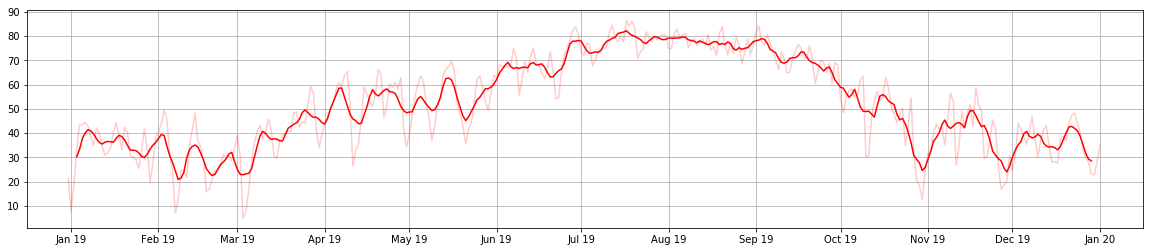

In [204]:
_ = plt.plot(daily_mean.index,daily_mean.temperature,c='red',alpha=.2)
_ = plt.plot(daily_mean.index,daily_mean.temperature.rolling(7,center=True).mean(),c='red',alpha=1)

fig,ax = plt.gcf(),plt.gca()
ax = utils.apply_mdates(ax,df.dt,'month')
fig.set_size_inches(20,4)
_ = plt.grid()

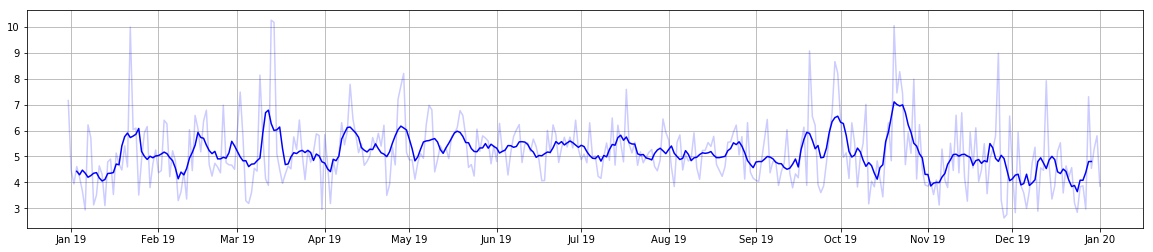

In [205]:
_ = plt.plot(daily_mean.index,daily_mean.windSpeed,c='blue',alpha=.2)
_ = plt.plot(daily_mean.index,daily_mean.windSpeed.rolling(7,center=True).mean(),c='blue',alpha=1)

fig,ax = plt.gcf(),plt.gca()
ax = utils.apply_mdates(ax,df.dt,'month')
fig.set_size_inches(20,4)
_ = plt.grid()

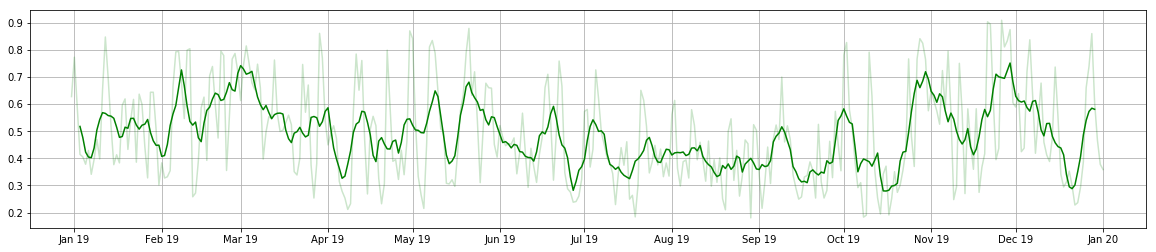

In [206]:
_ = plt.plot(daily_mean.index,daily_mean.humidity,c='green',alpha=.2)
_ = plt.plot(daily_mean.index,daily_mean.humidity.rolling(7,center=True).mean(),c='green',alpha=1)

fig,ax = plt.gcf(),plt.gca()
ax = utils.apply_mdates(ax,df.dt,'month')
fig.set_size_inches(20,4)
_ = plt.grid()

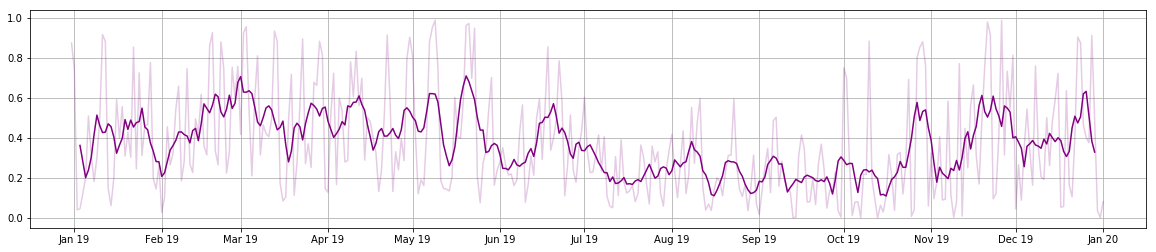

In [207]:
_ = plt.plot(daily_mean.index,daily_mean.cloudCover,c='purple',alpha=.2)
_ = plt.plot(daily_mean.index,daily_mean.cloudCover.rolling(7,center=True).mean(),c='purple',alpha=1)

fig,ax = plt.gcf(),plt.gca()
ax = utils.apply_mdates(ax,df.dt,'month')
fig.set_size_inches(20,4)
_ = plt.grid()

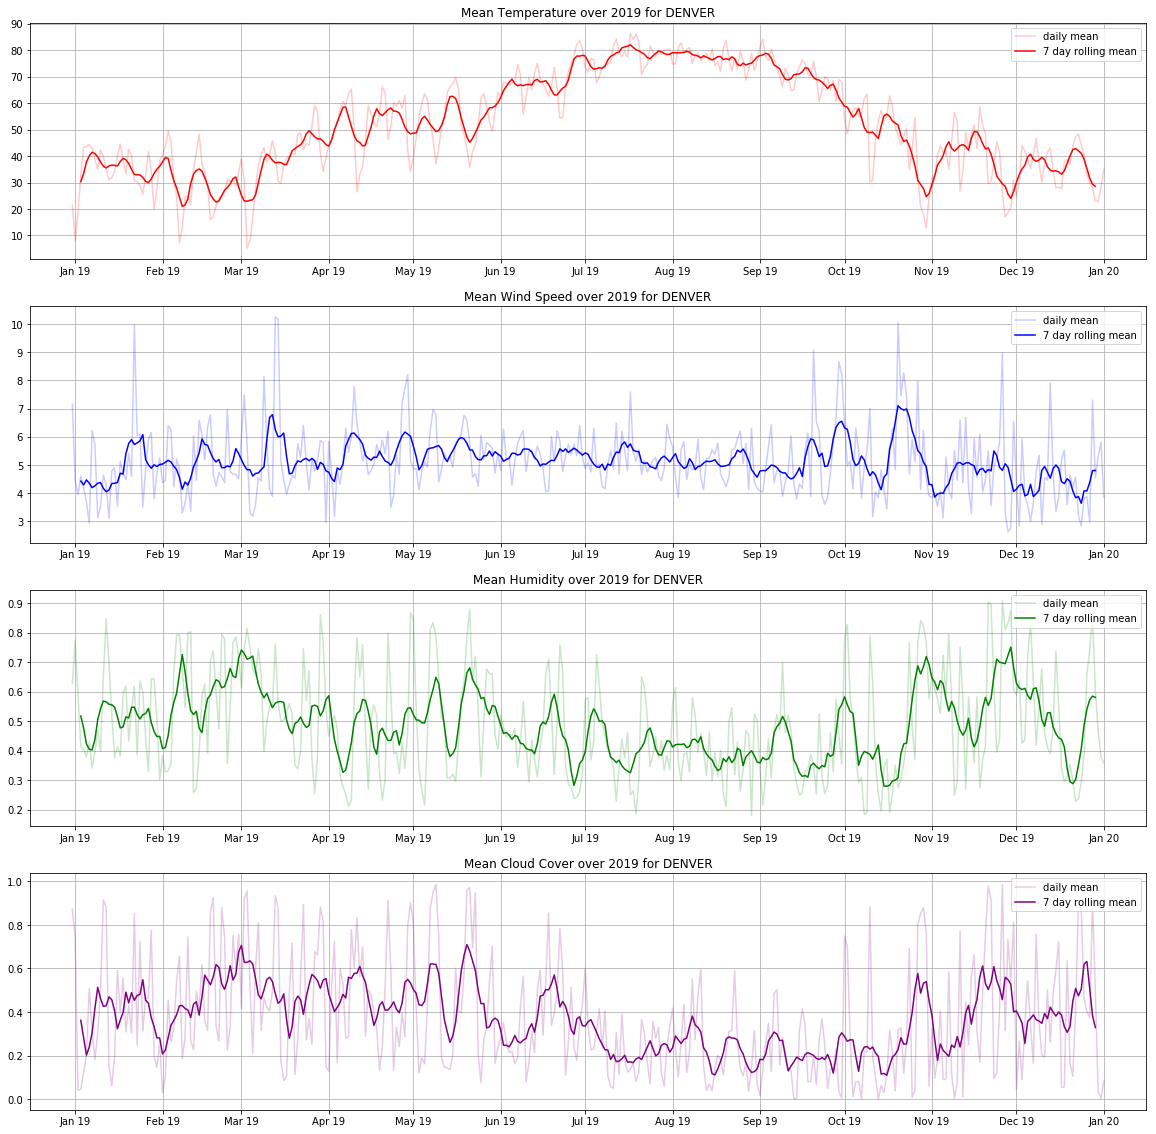

In [227]:
fig,axes = plt.subplots(4,1)
colors = 'red blue green purple'.split()
names = ['Temperature','Wind Speed','Humidity','Cloud Cover']
cols = 'temperature windSpeed humidity cloudCover'.split()
for idx,(color,name,col) in enumerate(zip(colors,names,cols)):
    _ = axes[idx].plot(daily_mean.index,daily_mean[col],c=color,alpha=.2,label='daily mean')
    _ = axes[idx].plot(daily_mean.index,daily_mean[col].rolling(7,center=True).mean(),c=color,alpha=1,label='7 day rolling mean')

    axes[idx] = utils.apply_mdates(axes[idx],daily_mean.index,'month')
    _ = axes[idx].legend(loc=1)
    _ = axes[idx].grid()
    title_text = f'Mean {name} over 2019 for {place.upper()}'
    _ = axes[idx].set_title(title_text)

fig.set_size_inches(20,20)

In [208]:
summary = utils.make_summary(df)

In [209]:
summary

{'mean_wind': 5.13,
 'mean_temp': 52.16,
 'mean_humidity': 0.488,
 'mean_cc': 0.368,
 'n_sunny': 264}

In [210]:
utils.save_summary(summary,place)

In [211]:
sunny_count = (daily_mean.cloudCover < .5).value_counts()

In [212]:
sunny_count

True     264
False    103
Name: cloudCover, dtype: int64

## Plots

In [233]:
import make_plots

In [213]:
place_list = glob('data/*')

In [214]:
place_list = [place.replace('data/','') for place in place_list]

['data/denver', 'data/london', 'data/christchurch']

In [229]:
latlong = utils.read_latlong()
place_list = list(latlong.keys())

places = {}
for place in place_list:
    places[place] = utils.load_year(place)
    #plot_single_place(places[place], place, plot_dir)

INFO:366 days downloaded
INFO:366 days downloaded
INFO:366 days downloaded


In [230]:
places.keys()

dict_keys(['denver', 'london', 'christchurch'])

In [241]:
means = {}
place_data = {}
for place in place_list:
    place_data[place] = utils.load_year(place)
    means[place] = make_plots.compute_means(place_data[place])


INFO:366 days downloaded
INFO:366 days downloaded
INFO:366 days downloaded


In [243]:
means[place][1]

,windSpeed,temperature,humidity,cloudCover
dt,,,,
2018-12-31,2.254615,62.053846,0.920000,0.980769
2019-01-31,10.872062,65.431169,0.715632,0.778675
2019-02-28,10.327040,62.602179,0.685991,0.751502
2019-03-31,9.009337,62.280293,0.774832,0.758540
2019-04-30,8.477097,52.534042,0.805778,0.464847
2019-05-31,8.242540,52.336398,0.795228,0.435645
2019-06-30,7.621625,44.532681,0.820931,0.530292
2019-07-31,7.950565,46.621922,0.833616,0.659704
2019-08-31,7.817070,44.866653,0.768871,0.475457


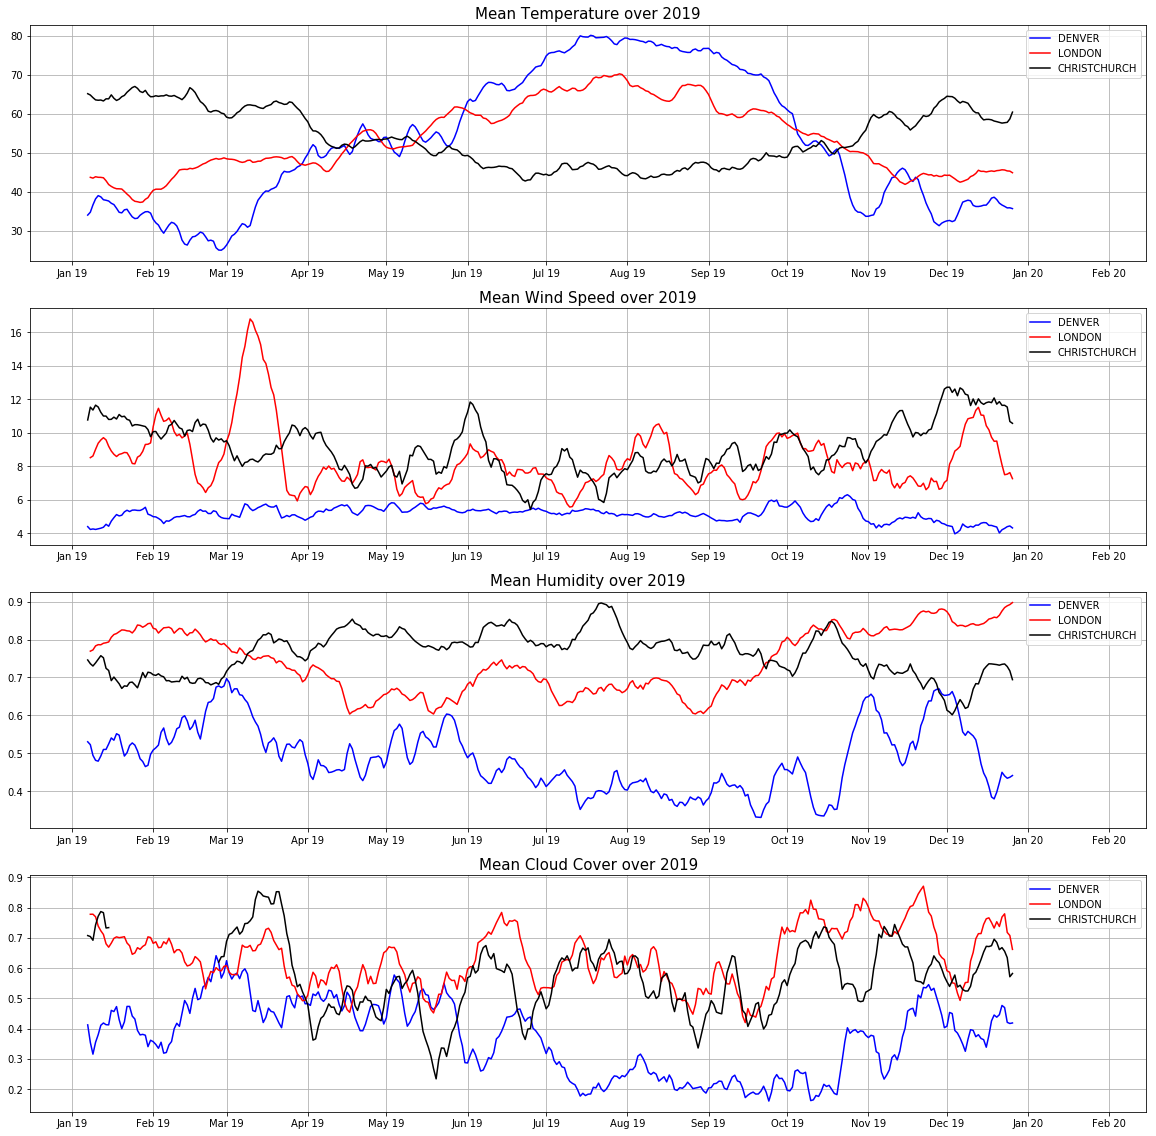

In [248]:
fig,axes = plt.subplots(4,1)
colors = 'red blue green purple'.split()
names = ['Temperature','Wind Speed','Humidity','Cloud Cover']
cols = 'temperature windSpeed humidity cloudCover'.split()

place2color = {}
place2color['london'] = 'red' ## red lion
place2color['christchurch'] = 'black' ## all blacks
place2color['denver'] = 'blue' ## broncos

for idx,(color,name,col) in enumerate(zip(colors,names,cols)):
    for place,(daily,monthly) in means.items():
        _ = axes[idx].plot(daily.index,daily[col].rolling(14,center=True).mean(),c=place2color[place],alpha=1,label=place.upper())

    axes[idx] = utils.apply_mdates(axes[idx],monthly.index,'month')
    _ = axes[idx].legend(loc=1)
    _ = axes[idx].grid()
    title_text = f'Mean {name} over 2019'
    _ = axes[idx].set_title(title_text,size=15)

fig.set_size_inches(20,20)